In [ ]:
# SANITY CHECK
# checking classic modal on MNIST and CIFAR10
# checking different sized (smaller) models on these datasets too

# start on wrapped images
# then again on unwrapped images

# need to be sure, my model architecture still is the best
# this will allow me to know if my low success is because og HP or the dataset being bad

# vgg16 style net (7conv, 3 lin) MNIST

In [1]:
import cv2
from PIL import Image

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math as maths

import os
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional


from tqdm import tqdm
from IPython.display import clear_output

import wandb
import pprint

from functions import import_imagedata, get_data, label_oh_tf,  Unwrap, ImageProcessor
from architectures import vgg16net, smallnet1, smallnet2
from loop_fns import loop, test_loop
from fns4wandb import build_optimizer, set_optimizer, train_model, train_log, log_test_score
import keras
from keras.datasets import fashion_mnist



/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [31]:


config ={
    'method': 'random'
}

metric = {'name': 'loss',
         'goal': 'minimize'}

config['metric'] = metric

param_dict ={
    'optimizer':{
        'values': ['adam']
    },
}

config['parameters'] = param_dict

param_dict.update({
    'epochs': {
        'value': 40
    }
})

"""
 'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'log_uniform_values',
        'min': 0.00001,
        'max': 0.01
      },
"""

param_dict.update({
   
    'weight_decay':{
            'values': [1e-5,2e-5, 3e-5,4e-5]
      },
    'loss_fn': {
            'values': ['MSE', 'CrossEntropy']
        },
     'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'log_uniform_values',
        'min': 0.00001,
        'max': 0.01
      },
    })


pprint.pprint(config)


col_dict = {
    'colour': 'grey',
    'size': [28,28],   #36,113
}



device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


sweep_id = wandb.sweep(config, project=f"SanityCheck_modelSize_7conv3lin_Fash_mnist_{col_dict['colour']}")

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'epochs': {'value': 40},
                'learning_rate': {'distribution': 'log_uniform_values',
                                  'max': 0.01,
                                  'min': 1e-05},
                'loss_fn': {'values': ['MSE', 'CrossEntropy']},
                'optimizer': {'values': ['adam']},
                'weight_decay': {'values': [1e-05, 2e-05, 3e-05, 4e-05]}}}
Using cuda:0 device
Create sweep with ID: 5u85rws1
Sweep URL: https://wandb.ai/antvis/SanityCheck_modelSize_7conv3lin_Fash_mnist_grey/sweeps/5u85rws1


In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_val,y_train,  y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

(28, 28)


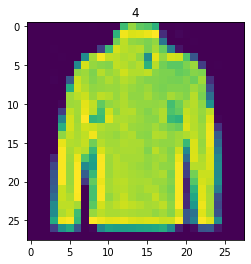

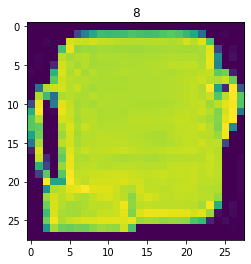

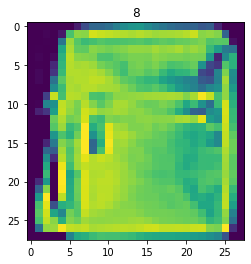

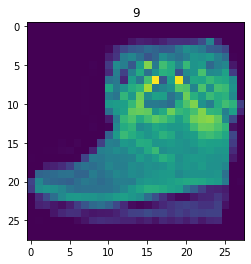

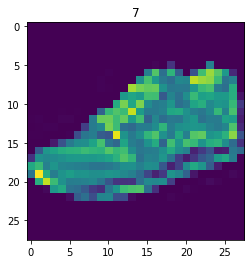

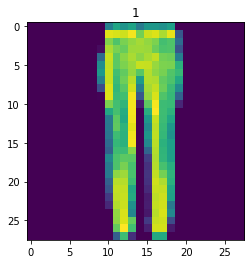

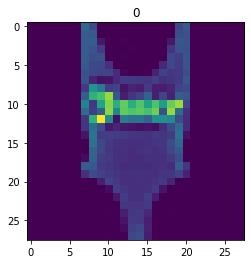

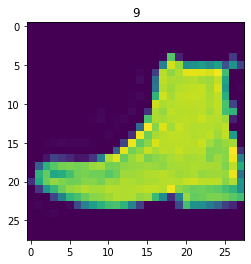

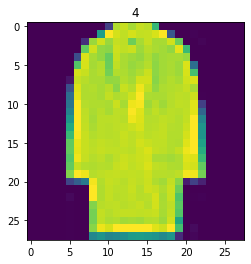

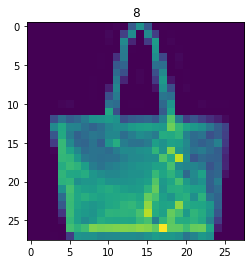

(28, 28, 1)


In [29]:
print(x_train[0].shape)
for i in range(10):
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.show()
    
x_train =[np.expand_dims(i, axis=2) for i in x_train]
print(x_train[5].shape)

In [6]:
xx,_,_,_,_,_ = get_data()
print(type(xx))
print(xx[0])
xx = cv2.imread(xx[0])
print(xx.shape)
xx = cv2.resize(xx,  (32, 32))
print(xx.shape)


print('xoxoxoxoxo')
print(x_train[0].shape)
d = cv2.ressize(x_train[0], (32,32))
print(d.shape)
plt.imshow(x_train[0])
plt.show()

<class 'numpy.ndarray'>
/its/home/nn268/optics/images/IDSW004_280423_1357_SW_075.JPG
(2880, 2880, 3)
(32, 32, 3)
xoxoxoxoxo
(28, 28)


AttributeError: module 'cv2' has no attribute 'ressize'

In [25]:
wandb.login()

True

In [23]:

                            # Common functions

def set_lossfn(lf):
    if lf =='MSE':
        loss_fn = nn.MSELoss()
    elif lf == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss()
    return loss_fn


def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        x_train, x_val,y_train,  y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
        x_train =[np.expand_dims(i, axis=2) for i in x_train]
        x_val =[np.expand_dims(i, axis=2) for i in x_val]
        x_test =[np.expand_dims(i, axis=2) for i in x_test]

        model =vgg16net(in_chan=1, f_lin_lay=2304, l_lin_lay=10).to(device) 
        if config.loss_fn == 'MSE':
            loss_fn = nn.MSELoss()
        elif config.loss_fn == 'CrossEntropy':
            loss_fn = nn.CrossEntropyLoss()
        
        e_count = 0
        #optimizer = build_optimizer(network, config.optimizer, config.learning_rate, config.weight_decay)
        #if e_count >= 20:
        optimizer = build_optimizer(model, config.optimizer, config.learning_rate, config.weight_decay)
        #else:
        #    optimizer = build_optimizer(model, config.optimizer, config.learning_rate)
        
        for epoch in range(config.epochs):

            t_loss, predict_list, t_num_correct, model, optimizer = loop(model, x_train, y_train, epoch, loss_fn, device, col_dict, num_classes=10, optimizer=optimizer)
            t_accuracy = (t_num_correct /len(x_train))*100
            v_loss, __, v_num_correct= loop(model, x_val, y_val, epoch, loss_fn, device,col_dict,num_classes=10, train=False) 
            v_accuracy= (v_num_correct / len(x_val))*100
            
            t_avg_loss =t_loss/len(x_train)
            v_avg_loss = v_loss /len(x_val)
            
            e_count +=1
            # logging
            wandb.log({'avg_train_loss': t_avg_loss, 'epoch':epoch})
            wandb.log({'avg_val_loss': v_avg_loss, 'epoch':epoch})
            wandb.log({'train_loss': t_loss, 'epoch':epoch})
            wandb.log({'val_loss': v_loss, 'epoch':epoch})
            wandb.log({'train_accuracy_%': t_accuracy, 'epoch':epoch})
            wandb.log({'val_accuracy_%': v_accuracy, 'epoch':epoch})

    
"""# title, config
def pipeline(hp): 
    
    title = f"{col_dict['colour']}_Wrapped_MNIST_7c3l_3232" #print(f"HPS_UNwrapped_{col_dict['colour']}")
    
    
    
    with wandb.init(project=title, config=hp):
        config = wandb.config
        model = build_net(lin_layer_size =config.lin_layer_size,dropout =config.dropout, first_lin_lay=config.first_linear, ks= config.kernal_size,in_chan= config.first_in_channel).to(device)
        loss_fn = set_loss_fn(config.loss_fn)
        
        train_model(model, x_train, y_train, x_val, y_val,loss_fn, config)
        test_loop(model, x_test, y_test, loss_fn, device, col_dict,title)
        
    return model"""
        

'# title, config\ndef pipeline(hp): \n    \n    title = f"{col_dict[\'colour\']}_Wrapped_MNIST_7c3l_3232" #print(f"HPS_UNwrapped_{col_dict[\'colour\']}")\n    \n    \n    \n    with wandb.init(project=title, config=hp):\n        config = wandb.config\n        model = build_net(lin_layer_size =config.lin_layer_size,dropout =config.dropout, first_lin_lay=config.first_linear, ks= config.kernal_size,in_chan= config.first_in_channel).to(device)\n        loss_fn = set_loss_fn(config.loss_fn)\n        \n        train_model(model, x_train, y_train, x_val, y_val,loss_fn, config)\n        test_loop(model, x_test, y_test, loss_fn, device, col_dict,title)\n        \n    return model'

In [ ]:
wandb.agent(sweep_id, train, count=15)

wandb: Agent Starting Run: 266yeu26 with config:
wandb: 	epochs: 40
wandb: 	learning_rate: 8.26888110851617e-05
wandb: 	loss_fn: MSE
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05


avg_train_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_val_loss,▆▆█▄▄▃▂▁▂▃▂▂▁▃▃▃▃▂▄▂▂▃▂▂▃▂▃▂▂▂▂▂▂▂▂▂▃▃▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy_%,█▂▅▃▁█▅▃▄▅▅▄▄▄▄▅▄▅▅▄▆▅▅▅▅▅▅▄▅▅▅▅▄▅▄▄▄▅▆▅
train_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy_%,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆█▄▄▃▂▁▂▃▂▂▁▃▃▃▃▂▄▂▂▃▂▂▃▂▃▂▂▂▂▃▂▂▂▂▃▃▂▂
avg_train_loss,0.09
avg_val_loss,0.09001
epoch,39
train_accuracy_%,9.93958


wandb: Agent Starting Run: 3tfuzcp4 with config:
wandb: 	epochs: 40
wandb: 	learning_rate: 2.338815433808195e-05
wandb: 	loss_fn: CrossEntropy
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-05


avg_train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_val_loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy_%,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy_%,▁▂▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
val_loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_train_loss,1.58656
avg_val_loss,1.59067
epoch,39
train_accuracy_%,87.37083


wandb: Agent Starting Run: h23dtrad with config:
wandb: 	epochs: 40
wandb: 	learning_rate: 0.00011864445792168932
wandb: 	loss_fn: MSE
wandb: 	optimizer: adam
wandb: 	weight_decay: 3e-05
